# **Computational Drug Discovery - Covid inhibitors**

Building a machine learning model using the ChEMBL bioactivity data.

steps -<br> 
   >1) Perform Descriptor Calculation and Exploratory Data Analysis<br>
   >2) Calculate molecular descriptors that are essentially quantitative description of the compounds in the dataset. <br>
   >3) Prepare this into a dataset for subsequent model building.<br>
   >4) Build a regression model of covid inhibitors using the random forest algorithm.<br>
   >5) Compare several ML algorithms for build regression models of covid inhibitors.


## Installing the required libraries

In [2]:
#!pip install pandas
#!pip install np
#!pip install matplotlib
#!pip install sklearn
#!pip install chembl_webresource_client
#!pip install seaborn
##Now in order to install rkdit use 
!conda install -c conda-forge rdkit


In [11]:

import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from matplotlib import style

from collections import Counter
from operator import itemgetter

from scipy.stats import skew
import pandas_profiling
%matplotlib inline


# data visualization
import seaborn as sns
%matplotlib inline

# Algorithms
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data

In [12]:
from platform import python_version
python_version()

'3.8.8'

In [13]:
import pandas as pd

# Data Collection

Download a sample dataset. Let me talk a bit about this dataset. It is downloaded from the ChEMBL official website. It is a dataset of 6900 molecules related to the COVID-19 with their intrinsic properties

### **Target search for covid**

In [19]:
# Target search for coronavirus
from rdkit import Chem
from chembl_webresource_client.new_client import new_client
target = new_client.target
target_query = target.search('SARS-Cov')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Severe acute respiratory syndrome-related coro...,SARS-CoV,32.0,False,CHEMBL4303836,[],ORGANISM,694009
1,[],Severe acute respiratory syndrome coronavirus 2,SARS-CoV-2,28.0,False,CHEMBL4303835,[],ORGANISM,2697049
2,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
3,[],Homo sapiens,"Serine--tRNA ligase, cytoplasmic",14.0,False,CHEMBL4523232,"[{'accession': 'P49591', 'component_descriptio...",SINGLE PROTEIN,9606
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,11.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
6,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


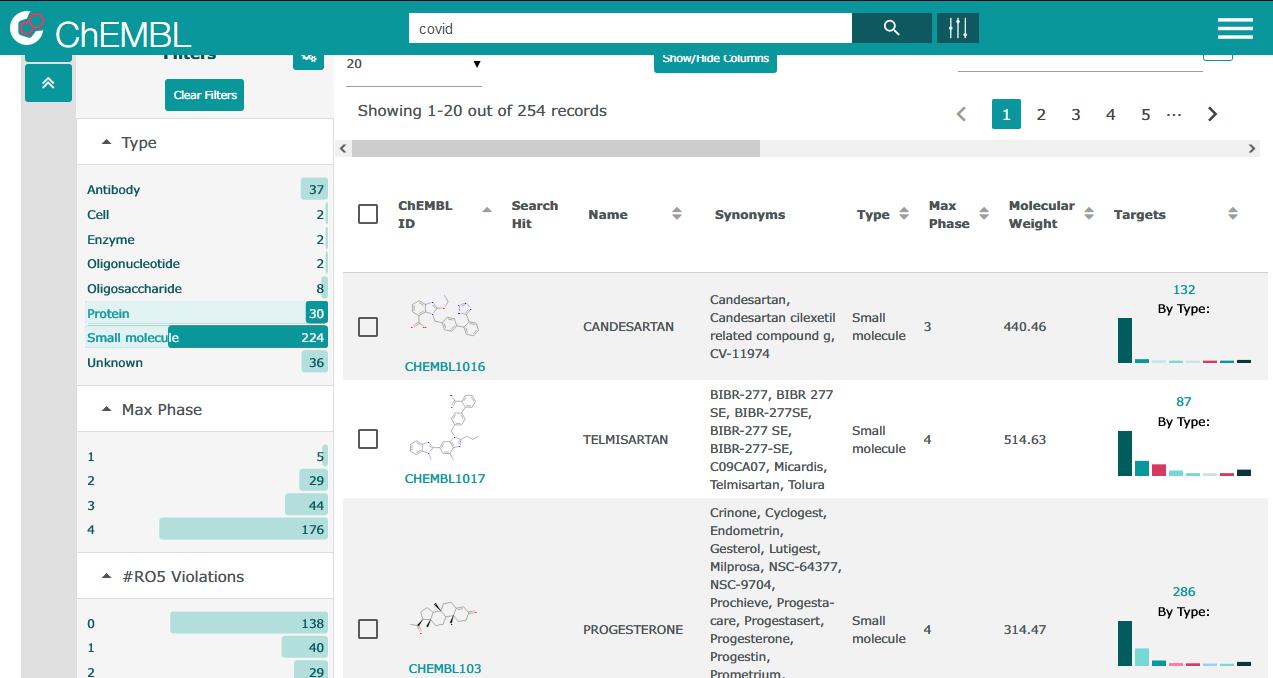

### Select and retrieve bio activity data of  SARS coronavirus 3C-like proteinase

In [15]:
selected_target = targets.target_chembl_id[6]
selected_target

'CHEMBL4523582'

In [4]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

In [5]:
df.to_csv('SARS-Cov.csv', index=False)

In [16]:
df = pd.read_csv('SARS-Cov.csv',sep=',')

In [17]:
df.head

<bound method NDFrame.head of     activity_comment  activity_id activity_properties assay_chembl_id  \
0    Dtt Insensitive     19964199                  []   CHEMBL4495583   
1    Dtt Insensitive     19964200                  []   CHEMBL4495583   
2    Dtt Insensitive     19964201                  []   CHEMBL4495583   
3    Dtt Insensitive     19964202                  []   CHEMBL4495583   
4    Dtt Insensitive     19964203                  []   CHEMBL4495583   
..               ...          ...                 ...             ...   
112  Dtt Insensitive     19964311                  []   CHEMBL4495583   
113  Dtt Insensitive     19964312                  []   CHEMBL4495583   
114  Dtt Insensitive     19964313                  []   CHEMBL4495583   
115  Dtt Insensitive     19964314                  []   CHEMBL4495583   
116  Dtt Insensitive     19964315                  []   CHEMBL4495583   

                                     assay_description assay_type  \
0    SARS-CoV-2 3CL-Pro 

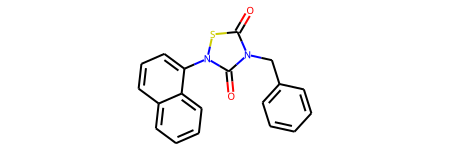

In [20]:
example =Chem.MolFromSmiles(df['canonical_smiles'][2])
example

In [21]:
def get_standard_value(chembl_id, standard_type):
    #Argument:
        #chembl_id : chemble id of the molecule
        #standard_type : IC50, ec50 etc
        
    #return: 
        #A (chembl_id, Bioactivity of the molecule)-tuple
    records = new_client.activity.filter(molecule_chembl_id=chembl_id).filter(standard_units='nM').filter(standard_type=standard_type)
    df = pd.DataFrame.from_dict(records)
    if len(df)>0:
        return (chembl_id,df['standard_value'][0])

In [22]:
x_list = list()
i=1
for chem_id in df['molecule_chembl_id']:
    f=get_standard_value(chem_id,'IC50')
    if f!= None:
        x_list.append(f)
        print(x_list[-1])
        print(f"{i}/{len(df['molecule_chembl_id'])}")
    i+=1
    print('----------------')

('CHEMBL480', '398.11')
1/117
----------------
('CHEMBL178459', '210.0')
2/117
----------------
('CHEMBL3545157', '60.0')
3/117
----------------
('CHEMBL297453', '730.0')
4/117
----------------
('CHEMBL4303595', '40.0')
5/117
----------------
('CHEMBL444186', '3190.0')
6/117
----------------
('CHEMBL55400', '2700.0')
7/117
----------------
('CHEMBL1886408', '200.0')
8/117
----------------
('CHEMBL505670', '72600.0')
9/117
----------------
('CHEMBL460499', '5000.0')
10/117
----------------
('CHEMBL1271993', '450.0')
11/117
----------------
('CHEMBL3665060', '5.0')
12/117
----------------
('CHEMBL1096979', '2400.0')
13/117
----------------
('CHEMBL164', '2000.0')
14/117
----------------
('CHEMBL1422849', '39390.0')
15/117
----------------
('CHEMBL284861', '2000.0')
16/117
----------------
('CHEMBL286080', '190.0')
17/117
----------------
('CHEMBL3963349', '130.0')
18/117
----------------
('CHEMBL480', '398.11')
19/117
----------------
('CHEMBL3797437', '360.0')
20/117
----------------
('

In [23]:
df1 = pd.DataFrame(x_list, columns=['ChEMBL ID', 'standard_value'])

In [111]:
df1.to_csv('SARS-Cov_bioactivity_data.csv', index=False)

### Handling Missing value :

In [24]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,Dtt Insensitive,19964199,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.39
1,Dtt Insensitive,19964200,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.21
2,Dtt Insensitive,19964201,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.08
3,Dtt Insensitive,19964202,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,1.58
4,Dtt Insensitive,19964203,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Dtt Insensitive,19964310,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,4.36
112,Dtt Insensitive,19964311,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,1.24
113,Dtt Insensitive,19964312,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,4.98
114,Dtt Insensitive,19964313,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75


In [25]:
i=0
sd = pd.read_csv('SARS-Cov_bioactivity_data.csv')
for num in sd['standard_value']:
    if num<=1000:
        i+=1
print(f"Number of the active class is {i}")

Number of the active class is 47


In [26]:
len(df2.canonical_smiles.unique())

102

In [27]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,Dtt Insensitive,19964199,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.39
1,Dtt Insensitive,19964200,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.21
2,Dtt Insensitive,19964201,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.08
3,Dtt Insensitive,19964202,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,1.58
4,Dtt Insensitive,19964203,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Dtt Insensitive,19964310,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,4.36
112,Dtt Insensitive,19964311,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,1.24
113,Dtt Insensitive,19964312,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,4.98
114,Dtt Insensitive,19964313,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75


## **Data pre-processing of the bioactivity data**

### **Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame**

In [28]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,390.0
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,210.0
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,80.0
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,1580.0
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,40.0
...,...,...,...
111,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,4360.0
112,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,1240.0
113,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],4980.0
114,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],750.0


In [29]:
df3.to_csv('SARS-Cov_bioactivity_data_preprocessed.csv', index=False)

In [30]:
df4 = pd.read_csv('SARS-Cov_bioactivity_data_preprocessed.csv')

In [31]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [32]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,390.0,active
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,210.0,active
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,80.0,active
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,1580.0,intermediate
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,40.0,active
...,...,...,...,...
97,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,4360.0,intermediate
98,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,1240.0,intermediate
99,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],4980.0,intermediate
100,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],750.0,active


In [33]:
df5.to_csv('SARS-Cov_bioactivity_data_curated.csv', index=False)

In [34]:
df_no_smiles = df5.drop(columns='canonical_smiles')

In [35]:
smiles = []

for i in df4.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [36]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL480,390.0,active,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1
1,CHEMBL178459,210.0,active,Cc1c(-c2cnccn2)ssc1=S
2,CHEMBL3545157,80.0,active,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1
3,CHEMBL297453,1580.0,intermediate,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...
4,CHEMBL4303595,40.0,active,O=C1C=Cc2cc(Br)ccc2C1=O
...,...,...,...,...
97,CHEMBL376488,4360.0,intermediate,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...
98,CHEMBL154580,1240.0,intermediate,C=CC(=O)c1ccc2ccccc2c1
99,CHEMBL354349,4980.0,intermediate,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21
100,CHEMBL1382627,750.0,active,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### Calculate descriptors

In [37]:
# Importing libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [38]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [39]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,369.368,3.51522,1.0,4.0
1,226.351,3.30451,0.0,5.0
2,334.400,3.26220,0.0,5.0
3,458.375,2.23320,8.0,11.0
4,237.052,2.22770,0.0,2.0
...,...,...,...,...
97,555.516,7.13050,1.0,4.0
98,182.222,3.20850,0.0,1.0
99,224.287,1.98190,2.0,2.0
100,249.275,1.45290,1.0,5.0


### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [40]:
df_combined = pd.concat([df5,df_lipinski], axis=1)

In [41]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,390.0,active,369.368,3.51522,1.0,4.0
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,210.0,active,226.351,3.30451,0.0,5.0
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,80.0,active,334.400,3.26220,0.0,5.0
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,1580.0,intermediate,458.375,2.23320,8.0,11.0
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,40.0,active,237.052,2.22770,0.0,2.0
...,...,...,...,...,...,...,...,...
97,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,4360.0,intermediate,555.516,7.13050,1.0,4.0
98,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,1240.0,intermediate,182.222,3.20850,0.0,1.0
99,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],4980.0,intermediate,224.287,1.98190,2.0,2.0
100,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],750.0,active,249.275,1.45290,1.0,5.0


## Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale, which is essential -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

    Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10−9−9
    Take the molar value and apply -log10
    Delete the standard_value column and create a new pIC50 column
    
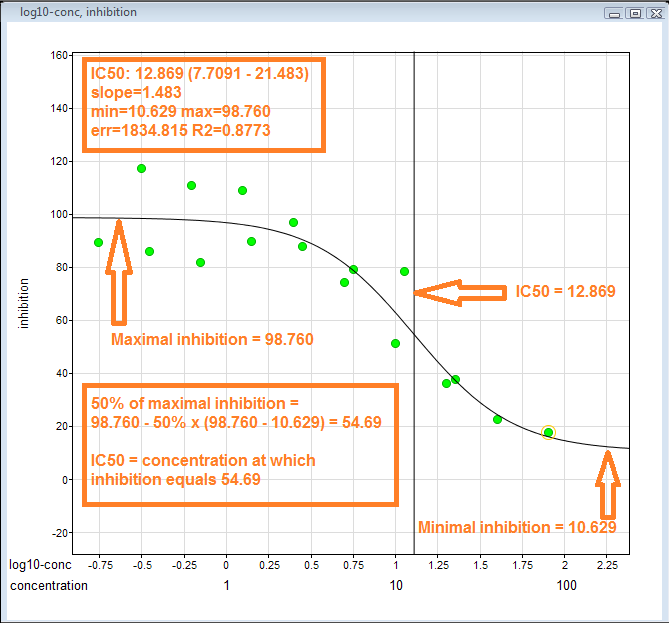

In [42]:
import numpy as np
def pIC50(dataframe):
    pIC50 = []
    for i in dataframe['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))
    dataframe['pIC50'] = pIC50
    x = dataframe.drop('standard_value_norm', 1)   
    return x
                   
def norm_value(dataframe):
    norm = []
    for i in dataframe['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)
    dataframe['standard_value_norm'] = norm
    x = dataframe.drop('standard_value', 1)    
    return x

We will first apply the norm_value() function to normalize the values in the standard_value column.

In [43]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,active,369.368,3.51522,1.0,4.0,390.0
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,active,226.351,3.30451,0.0,5.0,210.0
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,80.0
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,intermediate,458.375,2.23320,8.0,11.0,1580.0
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,237.052,2.22770,0.0,2.0,40.0
...,...,...,...,...,...,...,...,...
97,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,intermediate,555.516,7.13050,1.0,4.0,4360.0
98,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,intermediate,182.222,3.20850,0.0,1.0,1240.0
99,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],intermediate,224.287,1.98190,2.0,2.0,4980.0
100,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],active,249.275,1.45290,1.0,5.0,750.0


In [69]:
df_interm = pIC50(df_norm)
df_interm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,active,369.368,3.51522,1.0,4.0,6.408935
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,active,226.351,3.30451,0.0,5.0,6.677781
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,7.096910
3,CHEMBL297453,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)...,intermediate,458.375,2.23320,8.0,11.0,5.801343
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,237.052,2.22770,0.0,2.0,7.397940
...,...,...,...,...,...,...,...,...
97,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,intermediate,555.516,7.13050,1.0,4.0,5.360514
98,CHEMBL154580,C=CC(=O)c1ccc2ccccc2c1,intermediate,182.222,3.20850,0.0,1.0,5.906578
99,CHEMBL354349,C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.[Cl-],intermediate,224.287,1.98190,2.0,2.0,5.302771
100,CHEMBL1382627,Nc1ccc(S(=O)(=O)[N-]c2ncccn2)cc1.[Ag+],active,249.275,1.45290,1.0,5.0,6.124939


In [45]:
df_interm.to_csv('SARS-Cov_bioactivity_data_3class_pIC50.csv')

## Generating a Detailed Report of the data

In [46]:
df_interm.profile_report(title="Data Report - SARS-Cov")
profile = pandas_profiling.ProfileReport(df_interm) 
profile.to_file("Data Report SARS-Cov.html")

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [70]:
df_2class = df_interm[df_interm['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,active,369.368,3.51522,1.0,4.0,6.408935
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,active,226.351,3.30451,0.0,5.0,6.677781
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,7.096910
4,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,active,237.052,2.22770,0.0,2.0,7.397940
6,CHEMBL55400,Nc1ccc2cc3ccc(N)cc3nc2c1,active,209.252,2.55240,2.0,3.0,6.443697
7,CHEMBL1886408,CCOC(=O)Cc1ccc(-c2ccccc2)cc1,active,240.302,3.45920,0.0,2.0,6.698970
8,CHEMBL505670,O=[N+]([O-])c1ccc(Sc2cccc[n+]2[O-])c2nonc12,active,290.260,1.91560,0.0,7.0,7.000000
9,CHEMBL460499,CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O,active,257.265,0.81370,2.0,4.0,6.795880
12,CHEMBL1096979,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,active,257.246,-1.75620,7.0,7.0,6.853872
13,CHEMBL164,O=c1c(O)c(-c2cc(O)c(O)c(O)c2)oc2cc(O)cc(O)c12,active,318.237,1.69360,6.0,8.0,6.657577


In [48]:
df_2class.to_csv('SARS-Cov_bioactivity_data_2class_pIC50.csv')

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [49]:
### **Import library**

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

Text(0, 0.5, 'Frequency')

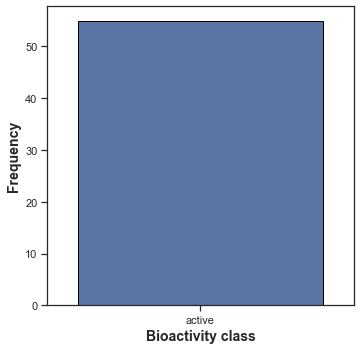

In [71]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.


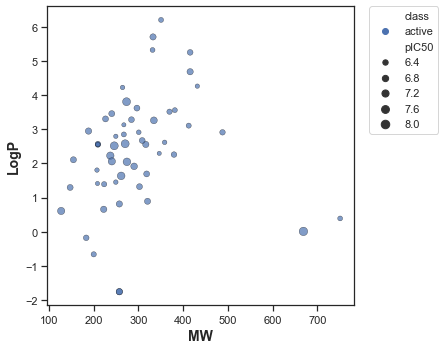

In [72]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


### **Box plots**

#### **pIC50 value**

Text(0, 0.5, 'pIC50 value')

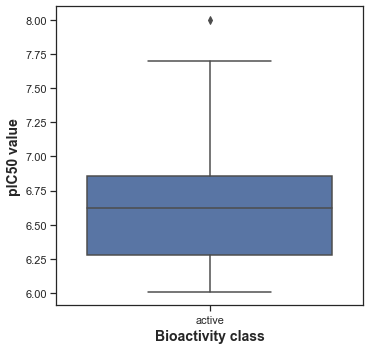

In [73]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')


## **Statistical analysis | Mann-Whitney U Test**

In [74]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results
mannwhitney('pIC50')

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,0.0,0.0,0.05,Different distribution (reject H0)


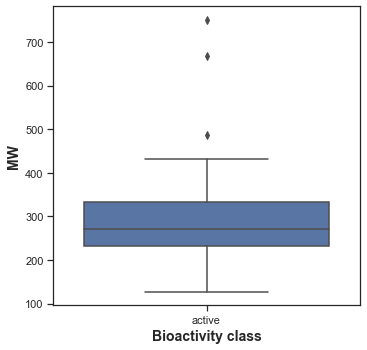

In [75]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')


mannwhitney('MW')

#### **LogP**

Text(0, 0.5, 'LogP')

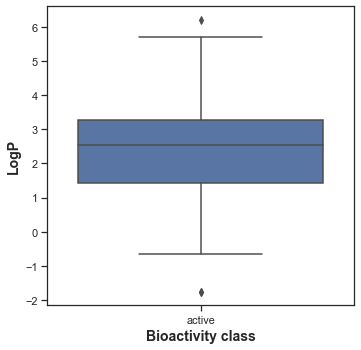

In [76]:

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

**Statistical analysis | Mann-Whitney U Test**

In [56]:
mannwhitney('LogP')

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,0.0,0.0,0.05,Different distribution (reject H0)


#### **NumHDonors**

Text(0, 0.5, 'NumHDonors')

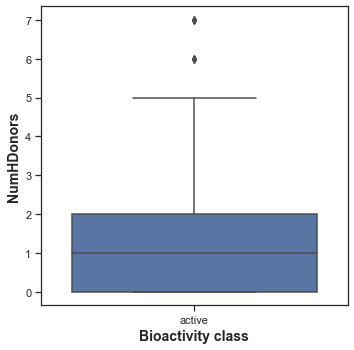

In [77]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')


**Statistical analysis | Mann-Whitney U Test**

In [78]:
mannwhitney('NumHDonors')

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,0.0,0.0,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

Text(0, 0.5, 'NumHAcceptors')

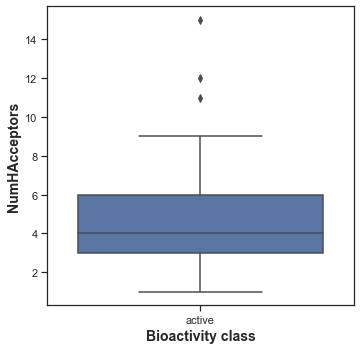

In [79]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')


**Statistical analysis | Mann-Whitney U Test**

In [80]:
mannwhitney('NumHAcceptors')

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,0.0,0.0,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives** except Log P.

Making a molecule.smi file which has Smiles and Chenmbl_id as two columns

In [81]:
df_2class.head(3)

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,active,369.368,3.51522,1.0,4.0,6.408935
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,active,226.351,3.30451,0.0,5.0,6.677781
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,active,334.400,3.26220,0.0,5.0,7.096910


### **Download PaDEL-Descriptor**

In [62]:
! pip install padelpy
! pip install wget

^C


In [ ]:
! python -m wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! python -m wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [82]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df_interm[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [83]:
! type molecule.smi | more

Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1        CHEMBL480
Cc1c(-c2cnccn2)ssc1=S   CHEMBL178459
O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1 CHEMBL3545157
O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1cc(O)c(O)c(O)c1)c1cc(O)c(O)c(O)c1  CHEMBL297453
O=C1C=Cc2cc(Br)ccc2C1=O CHEMBL4303595
CC(CN1CC(=O)NC(=O)C1)N1CC(=O)NC(=O)C1   CHEMBL444186
Nc1ccc2cc3ccc(N)cc3nc2c1        CHEMBL55400
CCOC(=O)Cc1ccc(-c2ccccc2)cc1    CHEMBL1886408
O=[N+]([O-])c1ccc(Sc2cccc[n+]2[O-])c2nonc12     CHEMBL505670
CCCCCCNC(=O)n1cc(F)c(=O)[nH]c1=O        CHEMBL460499
O=C1C(Cl)=C(N2CCOCC2)C(=O)N1c1ccc(Cl)c(Cl)c1    CHEMBL1271993
CN1CCN(C(=O)c2ccc(-c3ccc4c(C=O)c(O)ccc4c3)s2)CC1        CHEMBL3665060
NC(CO)C(=O)NNCc1ccc(O)c(O)c1O   CHEMBL1096979
O=c1c(O)c(-c2cc(O)c(O)c(O)c2)oc2cc(O)cc(O)c12   CHEMBL164
CCN1CCN(C(c2ccc(C(F)(F)F)cc2)c2ccc3cccnc3c2O)CC1        CHEMBL1422849
Cn1sc(=O)n(Cc2ccccc2)c1=O       CHEMBL284861
Oc1cc2c(cc1O)C(c1ccccc1)CNCC2   CHEMBL286080
COC(=O)CC[C@H](NC(=O)[C@H](CC(=O)OC)NC(=O)OCc1ccccc1)C(=O)N[C@H](C(

## **Calculate fingerprint descriptors**

### **PaDEL Descriptor**

To get the PaDEL Descriptors first, you have to create .smi file containing Smile and CHEMBL_id In this order only. Once you have this file, Use padel-Descriptor.jar file in directory : 'padel/PaDEL-Descriptor' to obtain 'descriptors_output.csv' in your working directory.<br>
Below is the image of software PaDEL-Descriptor.

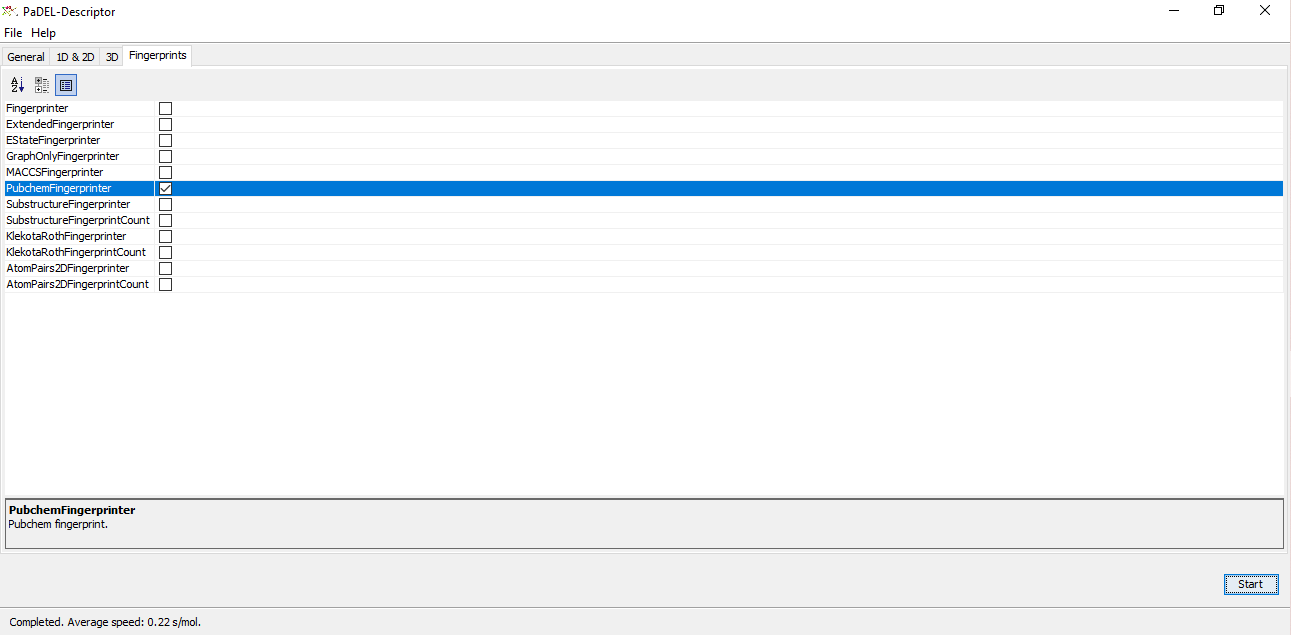

In [84]:
df_final = pd.read_csv('descriptors_output.csv')
#df_final.rename(columns = {'Name':'ChEMBL ID'}, inplace = True)
df_final.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL480,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL178459,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL3545157,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL297453,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4303595,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df_final_X = df_final.drop(columns=['Name'])

In [86]:
df_final_Y = df_interm['pIC50']
df_final_Y

0      6.408935
1      6.677781
2      7.096910
3      5.801343
4      7.397940
         ...   
97     5.360514
98     5.906578
99     5.302771
100    6.124939
101    5.714443
Name: pIC50, Length: 102, dtype: float64

#### Combining X and Y variable

In [88]:
dataset = pd.concat([df_final_X,df_final_Y], axis=1)
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.408935
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.677781
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.096910
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.801343
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.360514
98,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.906578
99,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.302771
100,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939


In [89]:
dataset.to_csv('SARS-Cov_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

## Random Forest Regressor

In [90]:
from sklearn.metrics import r2_score
X_train, X_test, Y_train, Y_test = train_test_split(df_final_X, df_final_Y, test_size=0.3)
i=0
for i in range(10):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, Y_train)
    r2 = model.score(X_test, Y_test)
    #print(r2)
    i+=1
Y_pred = model.predict(X_test)
print('R2 score of this model is',r2_score(Y_test, Y_pred))

R2 score of this model is 0.14904770892519603


### Brief about R2 Score :

The R2 score tells you how successfully your model accounts for the intrinsic variation in the data. The R2 score comes from running the trained model on the Validation data.  The R2 score predict the generalizability of your model – i.e. its expected performance on new, unseen data.

R-Squared only works as intended in a simple linear regression model with one explanatory variable. With a multiple regression made up of several independent variables, the R-Squared must be adjusted.

The adjusted R-squared compares the descriptive power of regression models that include diverse numbers of predictors. Every predictor added to a model increases R-squared and never decreases it. Thus, a model with more terms may seem to have a better fit just for the fact that it has more terms, while the adjusted R-squared compensates for the addition of variables and only increases if the new term enhances the model above what would be obtained by probability and decreases when a predictor enhances the model less than what is predicted by chance.

In an overfitting condition, an incorrectly high value of R-squared is obtained, even when the model actually has a decreased ability to predict. This is not the case with the adjusted R-squared

## **6. Scatter Plot of Experimental vs Predicted pIC50 Values**

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

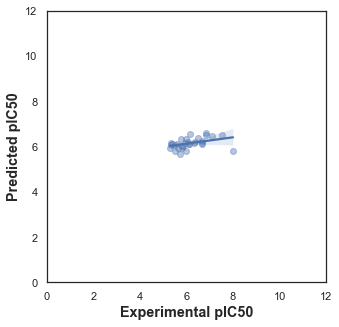

In [91]:

import seaborn as sns

import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("white")
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

# Conclusion

Random Forest Regressor is used to model the dataset. But as there is no clear relationship between descriptors and bioactivity (pIC50 values), the conventional Methods are not enough to predict bioactivity with high accuracy, we need something more powerful than conventional machine learning method like we need CNN, neural network or GANs to predicts these value more accurately.